# 1. Build an image segmentation model using pytorch

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
base_path = "/kaggle/input/bird-sound-dataset/Bird_Sound_Dataset/new_dataset/new_dataset"
train_image_dir = os.path.join(base_path, "train/images")
train_mask_dir = os.path.join(base_path, "train/masks")
val_image_dir = os.path.join(base_path, "valid/images")
val_mask_dir = os.path.join(base_path, "valid/masks")
test_image_dir = os.path.join(base_path, "test/images")
test_mask_dir = os.path.join(base_path, "test/masks")

print("Checking dataset paths")
for name, path in [("Train images", train_image_dir),
                   ("Train masks", train_mask_dir),
                   ("Val images", val_image_dir),
                   ("Val masks", val_mask_dir),
                   ("Test images", test_image_dir),
                   ("Test masks", test_mask_dir)]:
    print(f"{name}: {'Found' if os.path.exists(path) else 'Missing'}")

class BirdSoundDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.image_dir, self.image_files[idx])).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, self.mask_files[idx])).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

Checking dataset paths
Train images: Found
Train masks: Found
Val images: Found
Val masks: Found
Test images: Found
Test masks: Found


In [ ]:
print("\nCreating datasets")
train_dataset = BirdSoundDataset(train_image_dir, train_mask_dir, transform)
val_dataset = BirdSoundDataset(val_image_dir, val_mask_dir, transform)
test_dataset = BirdSoundDataset(test_image_dir, test_mask_dir, transform)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Creating datasets
Training samples: 1000
Validation samples: 200
Test samples: 300


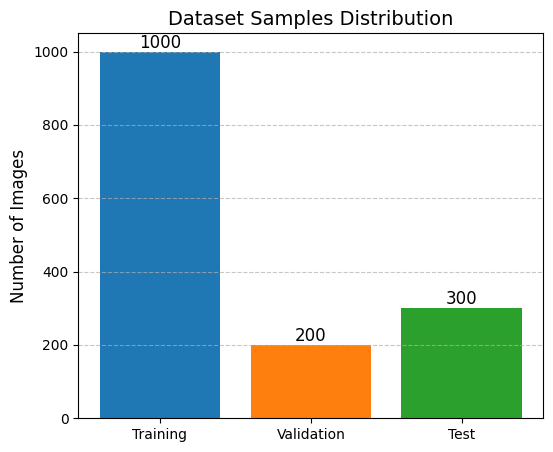

In [ ]:
plt.figure(figsize=(6, 5))
categories = ['Training', 'Validation', 'Test']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
counts = [len(train_dataset), len(val_dataset), len(test_dataset)]

bars = plt.bar(categories, counts, color=colors)

plt.title('Dataset Samples Distribution', fontsize=14)
plt.ylabel('Number of Images', fontsize=12)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom', fontsize=12)

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Train your model using [Bird sound datasets](https://yuad-my.sharepoint.com/personal/youshan_zhang_yu_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fyoushan%5Fzhang%5Fyu%5Fedu%2FDocuments%2FBird%5FSound%5FDataset&ga=1)

In [ ]:
class SpectrogramSegmenter(nn.Module):
    def __init__(self):
        super(SpectrogramSegmenter, self).__init__()

        self.down1 = self._conv_block(3, 64)
        self.down2 = self._conv_block(64, 128)
        self.down3 = self._conv_block(128, 256)
        self.down4 = self._conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)


        self.up1 = self._upconv_block(512, 256)
        self.up2 = self._upconv_block(512, 128)
        self.up3 = self._upconv_block(256, 64)


        self.out = nn.Conv2d(128, 1, kernel_size=1)

    def _conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def _upconv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):

        c1 = self.down1(x)
        p1 = self.pool(c1)

        c2 = self.down2(p1)
        p2 = self.pool(c2)

        c3 = self.down3(p2)
        p3 = self.pool(c3)

        c4 = self.down4(p3)


        u1 = self.up1(c4)
        u1 = torch.cat([u1, c3], dim=1)

        u2 = self.up2(u1)
        u2 = torch.cat([u2, c2], dim=1)

        u3 = self.up3(u2)
        u3 = torch.cat([u3, c1], dim=1)

        return torch.sigmoid(self.out(u3))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpectrogramSegmenter().to(device)
print("Model initialized and moved to", device)

Model initialized and moved to cuda


In [ ]:
num_epochs = 25
batch_size = 8
learning_rate = 0.001

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Starting training")
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0


    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()


    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            epoch_val_loss += loss.item()

    train_loss = epoch_train_loss / len(train_loader)
    val_loss = epoch_val_loss / len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

torch.save(model.state_dict(), "bird_sound_segmenter.pth")
print("Training complete. Model saved")

Starting training


Epoch 1/25: 100%|██████████| 125/125 [01:52<00:00,  1.11it/s]


Epoch 1: Train Loss: 0.1887, Val Loss: 0.1004


Epoch 2/25: 100%|██████████| 125/125 [01:36<00:00,  1.30it/s]


Epoch 2: Train Loss: 0.1096, Val Loss: 0.0888


Epoch 3/25: 100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch 3: Train Loss: 0.0946, Val Loss: 0.0835


Epoch 4/25: 100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch 4: Train Loss: 0.0898, Val Loss: 0.0785


Epoch 5/25: 100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch 5: Train Loss: 0.0833, Val Loss: 0.0727


Epoch 6/25: 100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch 6: Train Loss: 0.0822, Val Loss: 0.0819


Epoch 7/25: 100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch 7: Train Loss: 0.0805, Val Loss: 0.0698


Epoch 8/25: 100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch 8: Train Loss: 0.0776, Val Loss: 0.0723


Epoch 9/25: 100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch 9: Train Loss: 0.0769, Val Loss: 0.0711


Epoch 10/25: 100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


Epoch 10: Train Loss: 0.0750, Val Loss: 0.0740


Epoch 11/25: 100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch 11: Train Loss: 0.0732, Val Loss: 0.0704


Epoch 12/25: 100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch 12: Train Loss: 0.0716, Val Loss: 0.0741


Epoch 13/25: 100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch 13: Train Loss: 0.0729, Val Loss: 0.0736


Epoch 14/25: 100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


Epoch 14: Train Loss: 0.0706, Val Loss: 0.0716


Epoch 15/25: 100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch 15: Train Loss: 0.0710, Val Loss: 0.0696


Epoch 16/25: 100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch 16: Train Loss: 0.0703, Val Loss: 0.0693


Epoch 17/25: 100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


Epoch 17: Train Loss: 0.0670, Val Loss: 0.0690


Epoch 18/25: 100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


Epoch 18: Train Loss: 0.0677, Val Loss: 0.0689


Epoch 19/25: 100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


Epoch 19: Train Loss: 0.0658, Val Loss: 0.0701


Epoch 20/25: 100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


Epoch 20: Train Loss: 0.0662, Val Loss: 0.0671


Epoch 21/25: 100%|██████████| 125/125 [01:36<00:00,  1.30it/s]


Epoch 21: Train Loss: 0.0632, Val Loss: 0.0678


Epoch 22/25: 100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch 22: Train Loss: 0.0632, Val Loss: 0.0770


Epoch 23/25: 100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch 23: Train Loss: 0.0645, Val Loss: 0.0687


Epoch 24/25: 100%|██████████| 125/125 [01:35<00:00,  1.30it/s]


Epoch 24: Train Loss: 0.0615, Val Loss: 0.0753


Epoch 25/25: 100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch 25: Train Loss: 0.0608, Val Loss: 0.0712
Training complete. Model saved


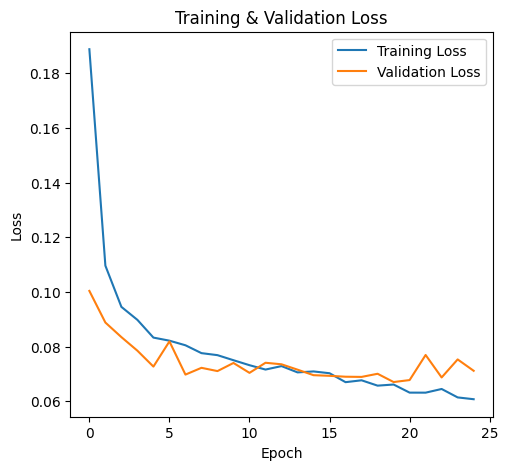

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)

# 3.Evaluate your model using the test images

In [ ]:
def calculate_iou(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    targets = (targets > threshold).float()

    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection

    return (intersection / (union + 1e-6)).item()

model.load_state_dict(torch.load("bird_sound_segmenter.pth"))
model.eval()

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
total_iou = 0
samples = 0

print("\nEvaluating on test set")
with torch.no_grad():
    for images, masks in tqdm(test_loader):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        if outputs.shape[2:] != masks.shape[2:]:
            masks = nn.functional.interpolate(masks, size=outputs.shape[2:], mode='nearest')

        batch_iou = calculate_iou(outputs, masks)
        total_iou += batch_iou * images.size(0)
        samples += images.size(0)

average_iou = total_iou / samples
print(f"Test IoU: {average_iou:.4f}")

/tmp/ipykernel_31/2039722494.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("bird_sound_segmenter.pth"))



Evaluating on test set


100%|██████████| 38/38 [00:29<00:00,  1.31it/s]

Test IoU: 0.6403


# 4. Your IoU score should be higher than 60

The test IoU score is 0.6403, or 64%, which is higher than the requirement of 60%, thus satisfying the desired numbers.

# 5. Write a 3-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


Link to path file: https://drive.google.com/file/d/13l08CHnrdpYdnegHtrqqlk-bf6rnYa_o/view?usp=drive_link

Link to reearch paper: https://www.researchgate.net/publication/391288057_Bird_Sound_Segmentation_Using_Deep_Learning

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file, and add paper link)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 0.6 -->10 points
     < 0.5  --> 0 points
     >= 0.5 & < 0.6  --> 1 point/0.01 higher
     

(6). Discussion - 10 points